## Packages installations and imports
(Run this section to ensure smooth operation for the Notebook)

In [ ]:
import numpy as np
import tensorflow as tf
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from pathlib import Path
import os

# Overview Dataset

1. Data Structure

In [ ]:
import gdown

gdown.download_folder("https://drive.google.com/drive/folders/19DLS6ZrfsxVq4IrRycPKrtt1TQanV9Em?usp=sharing", quiet=False, use_cookies=False)

Retrieving folder contents


Processing file 1tswGuA4JAO_fX8yQKlUTZoaXvHpeYnp8 meta_train.csv
Processing file 1Cz6q_m9fpAFePRZV6Ca2vMya4XvZDamX test_images.zip
Processing file 1tp1F1Xora43V5Ks3IjRaw40V3iAC6Wm2 train_images.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1tswGuA4JAO_fX8yQKlUTZoaXvHpeYnp8
To: /content/data/meta_train.csv
100%|██████████| 335k/335k [00:00<00:00, 110MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Cz6q_m9fpAFePRZV6Ca2vMya4XvZDamX
From (redirected): https://drive.google.com/uc?id=1Cz6q_m9fpAFePRZV6Ca2vMya4XvZDamX&confirm=t&uuid=0e4c3c00-5baf-4ad9-9be1-8d9f2d7996b4
To: /content/data/test_images.zip
100%|██████████| 274M/274M [00:02<00:00, 99.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1tp1F1Xora43V5Ks3IjRaw40V3iAC6Wm2
From (redirected): https://drive.google.com/uc?id=1tp1F1Xora43V5Ks3IjRaw40V3iAC6Wm2&confirm=t&uuid=45a2905b-f2df-4523-85e5-ebdfc7b6a24d
To: /content/data/train_images.zip
100%|██████████| 820M/820M [00:09<00:00, 88.1MB/s]
Download completed


['/content/data/meta_train.csv',
 '/content/data/test_images.zip',
 '/content/data/train_images.zip']

In [ ]:
# Import
import zipfile
with zipfile.ZipFile('data/train_images.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

In [ ]:
with zipfile.ZipFile('data/test_images.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

In [ ]:
import pandas as pd
data = pd.read_csv('data/meta_train.csv')

data.head()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  10407 non-null  object
 1   label     10407 non-null  object
 2   variety   10407 non-null  object
 3   age       10407 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 325.3+ KB


In [ ]:
data['age'] = data['age'].astype('object')
data.describe(include='object')

,image_id,label,variety,age
count,10407,10407,10407,10407
unique,10407,10,10,18
top,110381.jpg,normal,ADT45,70
freq,1,1764,6992,3077


2. Check for Duplicated Data

In [ ]:
print(data.isnull().sum())
print(data.duplicated().sum())

image_id    0
label       0
variety     0
age         0
dtype: int64
0


3. Checking the data distribution of age classes

Text(0, 0.5, 'count')

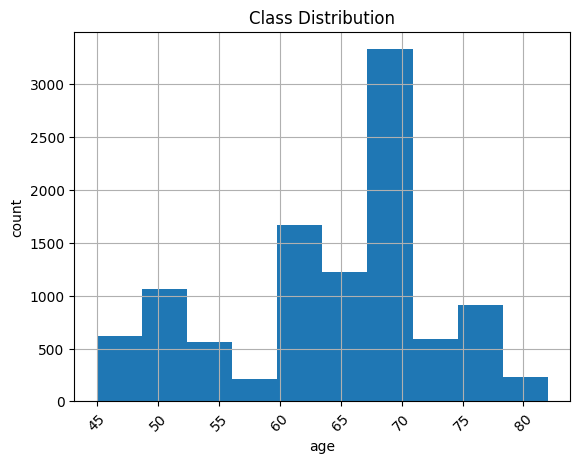

In [ ]:
# for Age feature
import matplotlib.pyplot as plt
data["age"].hist()
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.xlabel("age")
plt.ylabel("count")

In [ ]:
# Check for image resolution of given dataset as well as all images' format
from PIL import Image
from collections import Counter

train_dir = "data/train_images"

# Traverse all subdirectories (classes)
image_sizes = []
image_formats = []

# Loop to go through all disease classes within the train_images folder
# and its images to collect image resolution and format
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                with Image.open(image_path) as img:
                    image_sizes.append(img.size)
                    image_formats.append(img.format)  # Add format into image_formats array
            except Exception as e:
                print(f"Error reading {image_path}: {e}")

# Image sizes summary
size_counts = Counter(image_sizes)
print("Most common image sizes:")
for size, count in size_counts.most_common():
    print(f"{size}: {count} images")

# Image formats summary
format_counts = Counter(image_formats)
print("\nMost common image formats:")
for fmt, count in format_counts.most_common():
    print(f"{fmt}: {count} images")

In [ ]:
# Data augmentation
from tensorflow.keras import layers, models, optimizers, regularizers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomBrightness(0.2),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
])

I0000 00:00:1747375272.904134   50826 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Pipeline for Test for Task 3

1. Import and split training data and validation data

In [ ]:
from sklearn.model_selection import train_test_split
# Build a mapping with image_id and age
age_labels = dict(zip(data['image_id'], data['age']))

# Build a lookup table for variety → integer
age_names = sorted(data['age'].unique())

# 4. Function to load image and label
IMG_SIZE = (224, 224)

def load_image_and_age_label(filepath):
    filepath = filepath.numpy().decode("utf-8")

    # Read and preprocess image
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)

    # Get filename and lookup actual age (regression target)
    filename = os.path.basename(filepath)
    age = age_labels[filename]

    return image, np.float32(age)  # <- Ensure age is float32 for regression

# 5. Wrap inside tf.py_function
def tf_load_image_and_age(filepath):
    image, label = tf.py_function(
        func=load_image_and_age_label,
        inp=[filepath],
        Tout=(tf.float32, tf.float32)  # <- label is float32 now
    )
    image.set_shape([224, 224, 3])
    label.set_shape([])  # scalar regression target
    return image, label

# 6. Create dataset
filepaths = tf.data.Dataset.list_files('./data/train_images/*/*.jpg', shuffle=True)

full_dataset_task3 = filepaths.map(tf_load_image_and_age, num_parallel_calls=tf.data.AUTOTUNE)

# 8. Batch
full_dataset_task3 = full_dataset_task3.batch(32).prefetch(tf.data.AUTOTUNE)

# Step 6. Count total batches (excluding test set, assuming full_dataset_task2 is train + val only)
total_batches_task3 = len(full_dataset_task3)
print(f"Total batches (Task 3): {total_batches_task3}")

# Step 7. Calculate split sizes (80% train, 20% validation)
train_size_task3 = int(0.8 * total_batches_task3)
val_size_task3 = total_batches_task3 - train_size_task3  # remaining 20%

# Step 8. Split
train_dataset_task3 = full_dataset_task3.take(train_size_task3)
val_dataset_task3 = full_dataset_task3.skip(train_size_task3)

print(f"Train batches (Task 3): {len(train_dataset_task3)}")
print(f"Validation batches (Task 3): {len(val_dataset_task3)}")

# Step 9. Cache, shuffle, and prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_dataset_task3 = train_dataset_task3.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE).cache()
val_dataset_task3 = val_dataset_task3.cache().prefetch(buffer_size=AUTOTUNE).cache()

# Preview the dataset
for images, labels in train_dataset_task3.take(1):
    print(images.shape)
    print(labels.shape)

for images, labels in val_dataset_task3.take(1):
    print(images.shape)
    print(labels.shape)

Total batches (Task 3): 326
Train batches (Task 3): 260
Validation batches (Task 3): 66


2025-05-16 13:02:02.573258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 208 of 1000
2025-05-16 13:02:05.806940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-05-16 13:02:05.807033: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-16 13:02:05.807329: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)


2025-05-16 13:02:16.804188: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-16 13:02:16.804252: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2. Import test dataset for evaluation purposes

In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    'data/test_images',
    labels=None,                  # No labels needed for prediction
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 3469 files.


# Task 3 - Predicting age

- Build base models and function to build all models

In [ ]:
from tensorflow.keras.applications import EfficientNetB0, MobileNet, Xception
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

base_EfficientNetB0_model_task_3 = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,          # Exclude the final classification layer
    weights=None                # No pretrained weights
)

base_MobileNet_model_task_3 = MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,          # Exclude the final classification layer
    weights=None                # No pretrained weights
)

base_Xception_model_task_3 = Xception(
    input_shape=(224, 224, 3),
    include_top=False,          # Exclude the final classification layer
    weights=None                # No pretrained weights
)

In [ ]:
def build_EfficientNetB0_model_task_3(hp):
    model = tf.keras.Sequential([
          data_augmentation,
          normalization_layer,
          base_EfficientNetB0_model_task_3,
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'),
          tf.keras.layers.Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)),
          tf.keras.layers.Dense(1, activation='linear')
    ])

    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
    )

    return model

def build_MobileNet_model_task_3(hp):
    model = tf.keras.Sequential([
          data_augmentation,
          normalization_layer,
          base_MobileNet_model_task_3,
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'),
          tf.keras.layers.Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)),
          tf.keras.layers.Dense(1, activation='linear')
    ])

    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2 , sampling='log')

    model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
    )

    return model

def build_Xception_model_task_3(hp):
    model = tf.keras.Sequential([
          data_augmentation,
          normalization_layer,
          base_Xception_model_task_3,
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'),
          tf.keras.layers.Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)),
          tf.keras.layers.Dense(1, activation='linear')
    ])

    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
    )

    return model

- Setting up tuner for all models

In [ ]:
EfficientNetB0_task_3_tuner = kt.RandomSearch(
    build_EfficientNetB0_model_task_3,
    objective=kt.Objective('val_mae', direction='min'),
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='data/tuningtask3/EfficientNetB0',  # Directory to store the results
    project_name='EfficientNetB0_tuning'  # Name of the project
)

MobileNet_task_3_tuner = kt.RandomSearch(
    build_MobileNet_model_task_3,
    objective=kt.Objective('val_mae', direction='min'),
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='data/tuningtask3/MobileNet',  # Directory to store the results
    project_name='MobileNet_tuning'  # Name of the project
)

Xception_task_3_tuner = kt.RandomSearch(
    build_Xception_model_task_3,
    objective='val_mae',  # or 'val_mse'
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='data/tuningtask3/Xception',  # Directory to store the results
    project_name='Xception_tuning'  # Name of the project
)

Reloading Tuner from data/tuningtask3/EfficientNetB0/EfficientNetB0_tuning/tuner0.json
Reloading Tuner from data/tuningtask3/MobileNet/MobileNet_tuning/tuner0.json
Reloading Tuner from data/tuningtask3/Xception/Xception_tuning/tuner0.json


- EarlyStop and ReduceLROnPlateau function

In [ ]:
early_stop_model_task_3 = EarlyStopping(
    monitor='val_mae',
    patience=6,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

reduce_lr_model_task_3 = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.5,
    patience=4,
    mode='min',
    verbose=1,
    min_delta=1e-4
)

## EfficientNetB0 Tuner and Evaluation Results

In [ ]:
EfficientNetB0_task_3_tuner.search(
    train_dataset_task3,
    validation_data=val_dataset_task3,
    epochs=50,
    callbacks=[early_stop_model_task_3, reduce_lr_model_task_3],
    )

Trial 10 Complete [00h 25m 16s]
val_mae: 1.8507016897201538

Best val_mae So Far: 1.8507016897201538
Total elapsed time: 03h 40m 29s


In [ ]:
# Track the best model:
best_EfficientNetB0_model_task3 = EfficientNetB0_task_3_tuner.get_best_models(1)[0]
best_EfficientNetB0_model_task3.summary()
best_EfficientNetB0_model_task3.save('best_EfficientNetB0_model_task3.keras')

# Print best hyperparameters:
best__para_EfficientNetB0_model_task3 = EfficientNetB0_task_3_tuner.get_best_hyperparameters(1)[0]
print(best__para_EfficientNetB0_model_task3.values)

/home/herom/lintf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 432 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 4,335,741 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

{'dense_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.0002123999984466953}


## MobileNet Tuner and Evaluation Results

In [ ]:
MobileNet_task_3_tuner.search(
    train_dataset_task3,
    validation_data=val_dataset_task3,
    epochs=50,
    callbacks=[early_stop_model_task_3, reduce_lr_model_task_3],
    )

Trial 10 Complete [00h 09m 29s]
val_mae: 1.8546174764633179

Best val_mae So Far: 1.5071853399276733
Total elapsed time: 01h 56m 30s


In [ ]:
# Track the best model:
best_MobileNet_model_task3 = MobileNet_task_3_tuner.get_best_models(1)[0]
best_MobileNet_model_task3.summary()
best_MobileNet_model_task3.save('best_MobileNet_model_task3.keras')

# Print best hyperparameters:
best__para_MobileNet_model_task3 = MobileNet_task_3_tuner.get_best_hyperparameters(1)[0]
print(best__para_MobileNet_model_task3.values)

/home/herom/lintf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 172 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,491,521 (13.32 MB)

 Trainable params: 3,469,633 (13.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

{'dense_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.00018702715280418566}


## Xception Tuner and Evaluation Results

In [ ]:
Xception_task_3_tuner.search(
    train_dataset_task3,
    validation_data=val_dataset_task3,
    epochs=50,
    callbacks=[early_stop_model_task_3, reduce_lr_model_task_3],
    )

Trial 10 Complete [00h 00m 28s]

Best val_mae So Far: 1.309913158416748
Total elapsed time: 11h 22m 36s


ze 1572864 next 1400
2025-05-14 13:23:20.548963: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at c0f5fea00 of size 18264064 next 96662
2025-05-14 13:23:20.548964: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at c10769a00 of size 18264064 next 96879
2025-05-14 13:23:20.548965: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at c118d4a00 of size 3072 next 97342
2025-05-14 13:23:20.548966: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at c118d5600 of size 18264064 next 95841
2025-05-14 13:23:20.548967: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at c12a40600 of size 18264064 next 97306
2025-05-14 13:23:20.548968: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at c13bab600 of size 18264064 next 97313
2025-05-14 13:23:20.548968: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at c14d16600 of size 3072 next 97174
2025-05-14 13:23:20.548969: 

In [ ]:
# Track the best model:
best_Xception_model_task3 = Xception_task_3_tuner.get_best_models(1)[0]
best_Xception_model_task3.summary()
best_Xception_model_task3.save('best_Xception_model_task3.keras')

# Print best hyperparameters:
best__para_Xception_model_task3 = Xception_task_3_tuner.get_best_hyperparameters(1)[0]
print(best__para_Xception_model_task3.values)

54820608 totalling 295.30MiB
2025-05-14 13:23:20.588161: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1122] 1 Chunks of size 172742912 totalling 164.74MiB
2025-05-14 13:23:20.588162: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1122] 2 Chunks of size 194658304 totalling 371.28MiB
2025-05-14 13:23:20.588163: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1122] 1 Chunks of size 209271040 totalling 199.58MiB
2025-05-14 13:23:20.588164: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1122] 1 Chunks of size 221288704 totalling 211.04MiB
2025-05-14 13:23:20.588165: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1122] 1 Chunks of size 231292928 totalling 220.58MiB
2025-05-14 13:23:20.588167: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1126] Sum Total of in-use chunks: 5.43GiB
2025-05-14 13:23:20.588169: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1128] Total bytes in pool: 5827985408 memory_limit_: 5827985408 available by

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 21,331,753 (81.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

{'dense_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.006283286367334525}


In [ ]:
Xception_task_3_tuner.results_summary()

Results summary
Results in data/tuningtask3/Xception/Xception_tuning
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 07 summary
Hyperparameters:
dense_units: 256
dropout_rate: 0.3
learning_rate: 0.006283286367334525
Score: 1.309913158416748

Trial 06 summary
Hyperparameters:
dense_units: 128
dropout_rate: 0.3
learning_rate: 0.0015577695321475488
Score: 1.8726189136505127

Trial 05 summary
Hyperparameters:
dense_units: 192
dropout_rate: 0.3
learning_rate: 0.0001693152633727033
Score: 1.9297945499420166

Trial 04 summary
Hyperparameters:
dense_units: 128
dropout_rate: 0.3
learning_rate: 0.0010242211263663452
Score: 2.2472190856933594

Trial 00 summary
Hyperparameters:
dense_units: 256
dropout_rate: 0.3
learning_rate: 0.0010303205419268464
Score: 3.0864217281341553

Trial 03 summary
Hyperparameters:
dense_units: 192
dropout_rate: 0.5
learning_rate: 0.001096886962661042
Score: 3.125845193862915

Trial 01 summary
Hyperparameters:
dense_units: 192
dropout_rate: 0.5
l

## Evaluation and Final Training Session

1. Build all functions to calculate R2

In [ ]:
def extract_labels_and_preds(model, dataset):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_true.append(labels.numpy())
        y_pred.append(preds)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    return y_true, y_pred

In [ ]:
from sklearn.metrics import r2_score

def evaluate_r2(model, val_dataset):
    y_true, y_pred = extract_labels_and_preds(model, val_dataset)
    return r2_score(y_true, y_pred)

In [ ]:
# Import models for evaluation
from tensorflow.keras.models import load_model

best_EfficientNetB0_model_task_3 = load_model("best_EfficientNetB0_model_task_3.keras")
best_MobileNet_model_task_3 = load_model("final_MobileNet_model_task_3.keras")
best_Xception_model_task_3 = load_model("best_Xception_model_task_3.keras")

2. Calculate R2 Score for all models

In [ ]:
print("R2 Score of EfficientNetB0 model: ", evaluate_r2(best_EfficientNetB0_model_task_3, val_dataset_task3))

R2 Score of EfficientNetB0 model:  0.9018099308013916


2025-05-16 01:00:21.477131: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
print("R2 Score of MobileNet model: ",evaluate_r2(best_MobileNet_model_task_3, val_dataset_task3))

R2 Score of MobileNet model:  0.930384635925293


In [ ]:
print("R2 Score of Xception model: ",evaluate_r2(best_Xception_model_task_3, val_dataset_task3))

R2 Score of Xception model:  0.9432994723320007


3. Calculate Prediction Latency for all models

In [ ]:
import time
def calculate_prediction_time(model, dataset):
  # --- Warm-up Run ---
  for batch in dataset.take(1):
      _ = model.predict(batch, verbose=0)

  # --- Measure Prediction Time ---
  start = time.time()
  total_images = 0

  for batch in dataset:
      _ = model.predict(batch, verbose=0)
      total_images += batch.shape[0]

  end = time.time()

  # --- Results ---
  total_time = end - start
  per_image_time = (total_time / total_images) * 1000  # in ms

  print(f"Predicted {total_images} images in {total_time:.2f} seconds")
  print(f"Average prediction time per image: {per_image_time:.2f} ms")

In [ ]:
calculate_prediction_time(best_EfficientNetB0_model_task_3,test_dataset)

Predicted 3469 images in 7.34 seconds
Average prediction time per image: 2.12 ms


2025-05-16 01:02:23.360536: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
calculate_prediction_time(best_MobileNet_model_task_3,test_dataset)

Predicted 3469 images in 5.63 seconds
Average prediction time per image: 1.62 ms


In [ ]:
calculate_prediction_time(best_Xception_model_task_3,test_dataset)

Predicted 3469 images in 9.80 seconds
Average prediction time per image: 2.83 ms


4. Train Final chosen model

In [ ]:
final_MobileNet_model_task_3_history = best_MobileNet_model_task_3.fit(train_dataset_task3, validation_data=val_dataset_task3, epochs=50, callbacks=[early_stop_model_task_3, reduce_lr_model_task_3])

Epoch 1/50


I0000 00:00:1747375356.699137   50956 cuda_dnn.cc:529] Loaded cuDNN version 90300


260/260 ━━━━━━━━━━━━━━━━━━━━ 50s 167ms/step - loss: 58.1701 - mae: 5.9752 - val_loss: 5.1024 - val_mae: 1.4533 - learning_rate: 6.2500e-05
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - loss: 59.8223 - mae: 6.1146 - val_loss: 5.7716 - val_mae: 1.7496 - learning_rate: 6.2500e-05
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - loss: 59.9532 - mae: 6.0858 - val_loss: 4.6533 - val_mae: 1.4256 - learning_rate: 6.2500e-05
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - loss: 57.6982 - mae: 5.9584 - val_loss: 5.9065 - val_mae: 1.6375 - learning_rate: 6.2500e-05
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 57.6996 - mae: 6.0331 - val_loss: 5.6333 - val_mae: 1.6113 - learning_rate: 6.2500e-05
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - loss: 56.8349 - mae: 5.9595 - val_loss: 4.4256 - val_mae: 1.3725 - learning_rate: 6.2500e-05
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - loss: 58.2167 - mae: 6.0325 - val_loss: 4.4685 - val_m

In [ ]:
# Save the final model for prediction use
best_MobileNet_model_task_3.save('final_MobileNet_model_task_3.keras')

5. Plot the final model's training session

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='mae', model_name='None'):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'Training and Validation Loss - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy or Other Metric
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_metric, 'bo-', label=f'Training {metric_name}')
    plt.plot(epochs, val_metric, 'ro-', label=f'Validation {metric_name}')
    plt.title(f'Training and Validation {metric_name} - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    plt.tight_layout()
    plt.show()

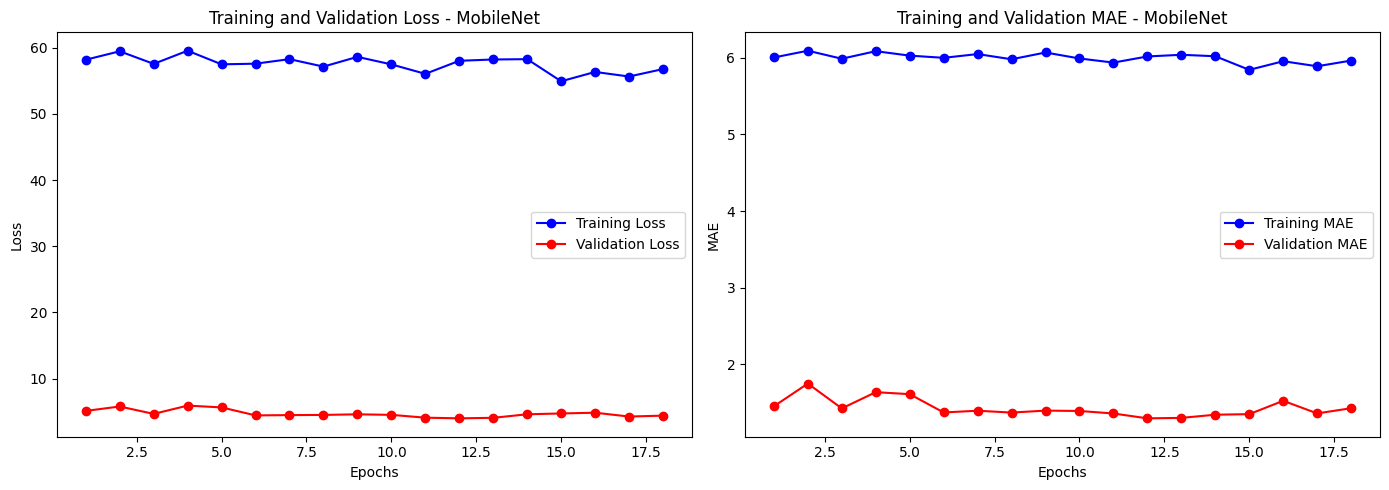

In [ ]:
plot_learning_curve(final_MobileNet_model_task_3_history.history['loss'], final_MobileNet_model_task_3_history.history['val_loss'],
                    final_MobileNet_model_task_3_history.history['mae'], final_MobileNet_model_task_3_history.history['val_mae'],
                    metric_name='MAE', model_name="MobileNet")